# 2. Prediction without Km and Vmax

This notebook contains the prediction part of the POC without the features of Km and Vmax. The cleaned dataset is loaded and trained on multiple models. The best model will be selected and used to predict the test dataset. The same models will be trained as the `prediction.ipynb` notebook. The only difference is that the features of Km and Vmax are not included in the training dataset.

This is to check if the model is able to predict the test dataset without the features of Km and Vmax.

In [80]:
# import dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [81]:
# load the data

df_original = pd.read_csv("./data/cleaned_data.csv")

### Removal of Km and Vmax

In [82]:
# drop the columns that are not needed

columns_removed = ["km", "vmax"]
df_original.drop(columns=columns_removed, inplace=True)

In [83]:
df = df_original.select_dtypes(include=[np.number])

## 2.1 Preprocessing

### 2.1.1 Train Test Split

In [84]:
# shuffle the data

df_shuffle = df.sample(frac=1, random_state=RANDOM_SEED)

In [85]:
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(columns=['kcat'])
y = df_shuffle['kcat']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=RANDOM_SEED)

### 2.1.2 Standardization

In [86]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()


X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])

X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

### 2.1.3 Polynomials - Penalisation

In [87]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stand)
X_val_poly = poly.transform(X_val_stand)
X_train_poly.shape

(1696, 112)

In [88]:
# Using Cross validation to determine the best alpha for the Lasso regression

from sklearn.model_selection import cross_val_score
from sklearn import linear_model

Alpha = np.logspace(-3,0)
print(Alpha)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for a in Alpha:
    lasso = linear_model.Lasso(a, max_iter=3000)
    scores = cross_val_score(lasso, X_train_poly, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

train = linear_model.Lasso(Alpha[max_index], max_iter=3000)
train.fit(X_train_poly,y_train)

[0.001      0.0011514  0.00132571 0.00152642 0.00175751 0.00202359
 0.00232995 0.0026827  0.00308884 0.00355648 0.00409492 0.00471487
 0.00542868 0.00625055 0.00719686 0.00828643 0.00954095 0.01098541
 0.01264855 0.01456348 0.01676833 0.01930698 0.02222996 0.02559548
 0.02947052 0.03393222 0.0390694  0.04498433 0.05179475 0.05963623
 0.06866488 0.07906043 0.09102982 0.10481131 0.12067926 0.13894955
 0.15998587 0.184207   0.21209509 0.24420531 0.28117687 0.32374575
 0.37275937 0.42919343 0.49417134 0.5689866  0.65512856 0.75431201
 0.86851137 1.        ]


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.230e+01, tolerance: 4.189e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.181e+00, tolerance: 4.198e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase 

Lasso(alpha=0.016768329368110083, max_iter=3000)

The optimal alpha is 0.016768329368110083
The training score of the optimal alpha is 0.6041100387537552
The validation score of the optimal alpha is 0.5841395217598896


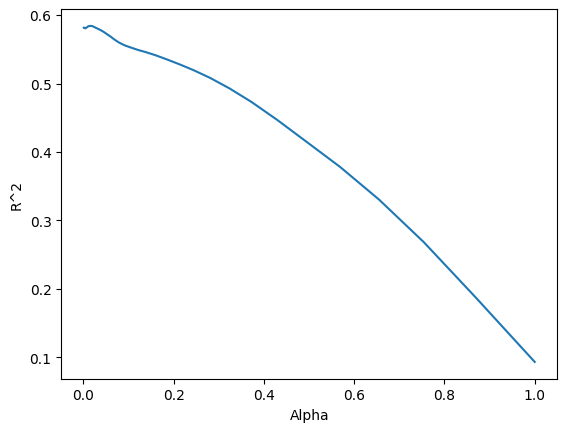

In [89]:
# plotting the best alpha

plt.plot(Alpha, cv_scores)
plt.xlabel('Alpha')
plt.ylabel('R^2')

print('The optimal alpha is', Alpha[max_index])
print('The training score of the optimal alpha is', train.score(X_train_poly,y_train))
print('The validation score of the optimal alpha is', max_value)

plt.show()

In [90]:
# Calculate the best degree to use using the average score with cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

avg_scores = [None] * 3
sd_scores = [None] * 3 	  # a degree > 3 will give R^2 in the (-) thousands
for i in np.arange(0,3):
    reg_poly = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train_poly, y_train, scoring = 'r2', cv=5)

    avg_scores[i] = scores.mean()
    sd_scores[i] = np.sqrt(scores.var())/np.sqrt(5)
    print("Order " + str(i) + ": avg R^2 = " + str(avg_scores[i]))

Order 0: avg R^2 = -0.0019317236601055666
Order 1: avg R^2 = 0.5797120686183105
Order 2: avg R^2 = -21.312623647859823


In [91]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])

reg_poly2.fit(X_train, y_train)

poly_train_res = reg_poly2.score(X_train, y_train)
poly_val_res = reg_poly2.score(X_val, y_val)

print(str(poly_train_res) + "\n" + str(poly_val_res))

0.6298313393730932
-2.9072988590402448e+22


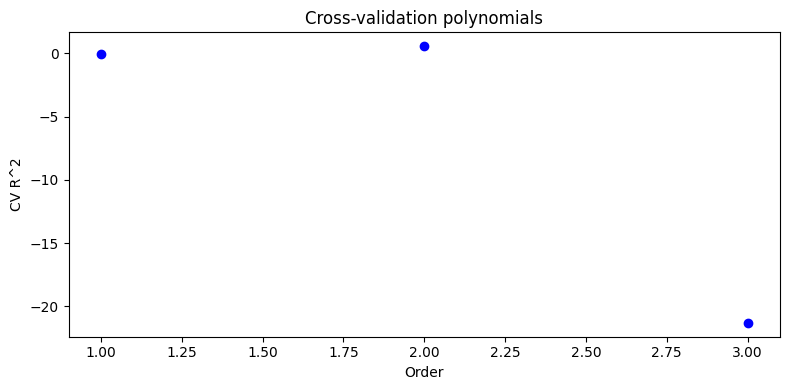

In [92]:
# Plotting the results

fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order")
ax.set_ylabel("CV R^2")
plt.tight_layout()
plt.show()

In [93]:
# The best order with the maximum R^2?

max_value = max(avg_scores)
max_index = avg_scores.index(max_value)
print('The order with maximum R^2 is '+ str(max_index))

The order with maximum R^2 is 1


In [94]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])

reg_poly2.fit(X_train, y_train)

poly_train_res = reg_poly2.score(X_train, y_train)
poly_val_res = reg_poly2.score(X_val, y_val)

if poly_val_res < 0:
	poly_val_res = 0

print(str(poly_train_res) + "\n" + str(poly_val_res))

0.6298313393730932
0


## 2.2 Model Selection

### 2.2.1 KNN

In [95]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,100)
cv_scores = []
sd_scores = []

for k in K:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

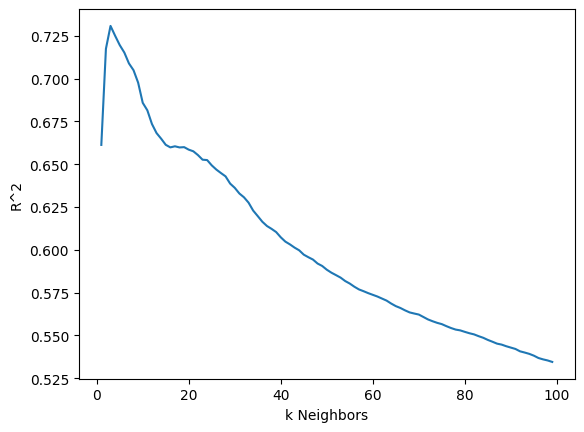

The best k is 3


In [96]:
# Plotting the results

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

In [97]:
knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stand, y_train)

knn_train_res = knn.score(X_train_stand, y_train)
knn_val_res = knn.score(X_val_stand, y_val)

print(str(knn_train_res) + "\n" + str(knn_val_res))

0.8896262563778299
0.7545115757156032


### 2.2.2 Random Forest

In [98]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 200)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validation
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible

rf_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
93 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 150, 152, 154,
                                                         156, 158, ...]},
                   random_state=42, verbose=2)

In [99]:
# show the training and validated R^2 for the best model from the random search

best_rf_est = rf_random.best_estimator_

print(best_rf_est.score(X_train_stand, y_train))
print(best_rf_est.score(X_val_stand, y_val))

0.9050655684534482
0.80064303179861


In [100]:
# retrieve the best parameters of the best model

rf_random.best_params_

{'n_estimators': 216,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 250,
 'max_features': 'sqrt',
 'max_depth': 11,
 'criterion': 'squared_error'}

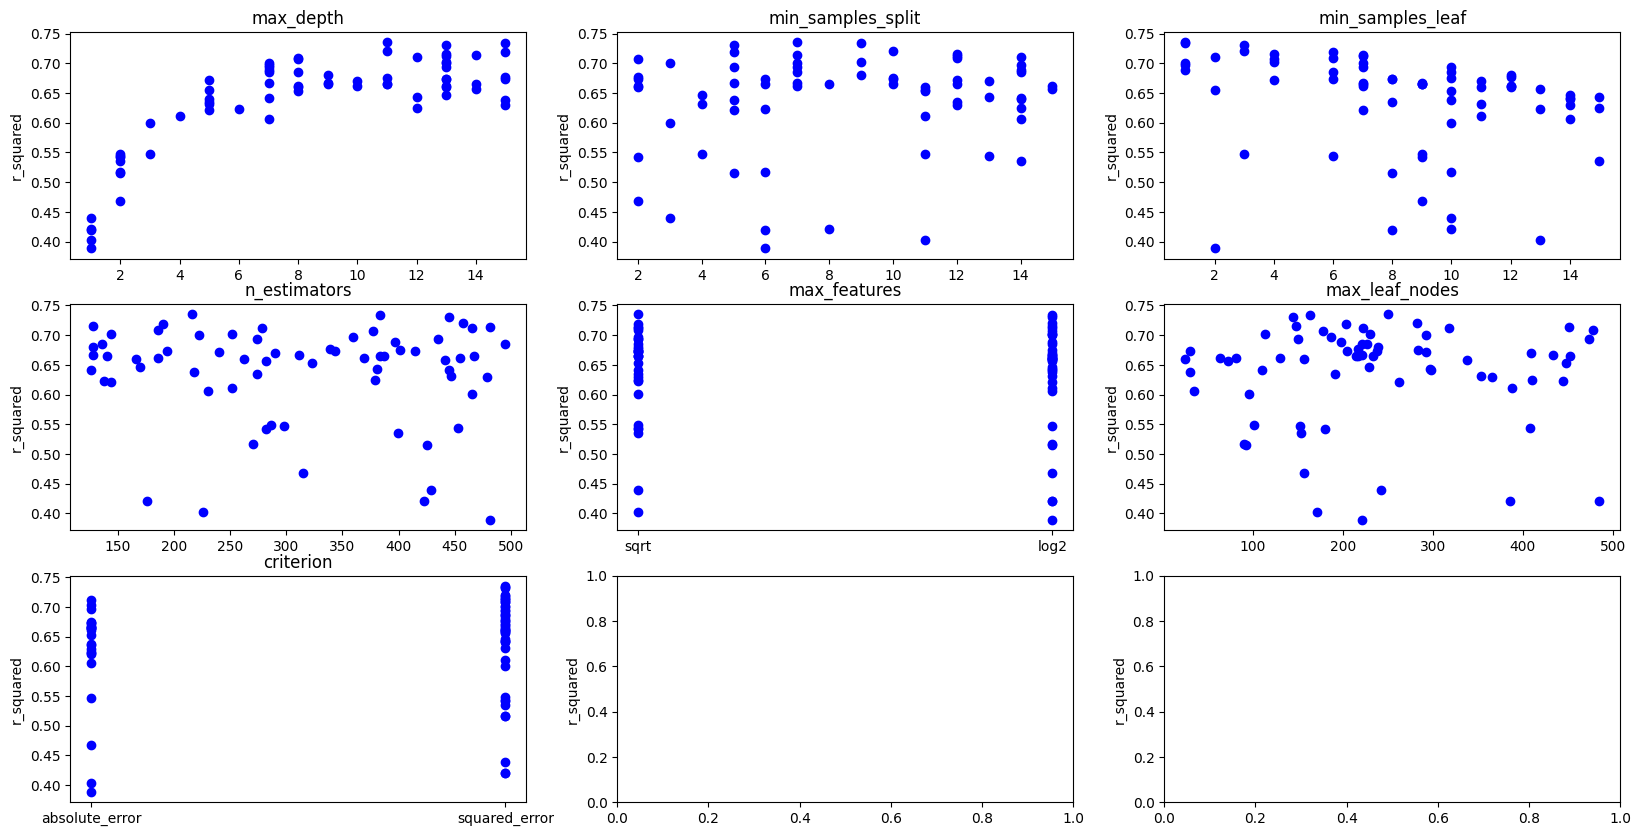

In [101]:
# plotting out the hyperparameters, so we can check which values to use for the grid search. 

out = pd.DataFrame(rf_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')


### 2.2.3 Random Forest - Grid Search

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error']
n_estimators = [225]
max_features = ['sqrt']
max_depth = [13]
min_samples_split = [3]
min_samples_leaf = [1]
max_leaf_nodes = [150]


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models  parallel as possible
rf_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [13],
                         'max_features': ['sqrt'], 'max_leaf_nodes': [150],
                         'min_samples_leaf': [1], 'min_samples_split': [3],
                         'n_estimators': [225]},
             verbose=2)

In [103]:
# show the training and validated R^2 for the best model from the random search

best_rf_grid_est = rf_grid.best_estimator_

rf_train_res = best_rf_grid_est.score(X_train_stand, y_train)
rf_val_res = best_rf_grid_est.score(X_val_stand, y_val)

print(str(rf_train_res) + "\n" + str(rf_val_res))

0.9361240730082647
0.8104275550844399


In [104]:
# retrieve the best parameters of the best model

rf_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': 13,
 'max_features': 'sqrt',
 'max_leaf_nodes': 150,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 225}

## 2.3 Gradient Boosting

In [105]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile']
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter=100, cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)

gbm_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
252 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\denis\.virtualenvs\poc-protein-feature

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_node...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

In [106]:
# Show the validated R^2 for the best model from the random search
best_gbm_rand = gbm_random.best_estimator_

# calculate the training and validation scores of the best estimator
gb_train_res = best_gbm_rand.score(X_train_stand, y_train)
gb_val_res = best_gbm_rand.score(X_val_stand, y_val)

print(str(gb_train_res) + "\n" + str(gb_val_res))

0.9679461810294321
0.8112958778740254


In [107]:
# get the best parameters of the best model
gbm_random.best_params_

{'n_estimators': 410,
 'min_samples_split': 12,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 230,
 'max_features': 'log2',
 'max_depth': 9,
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

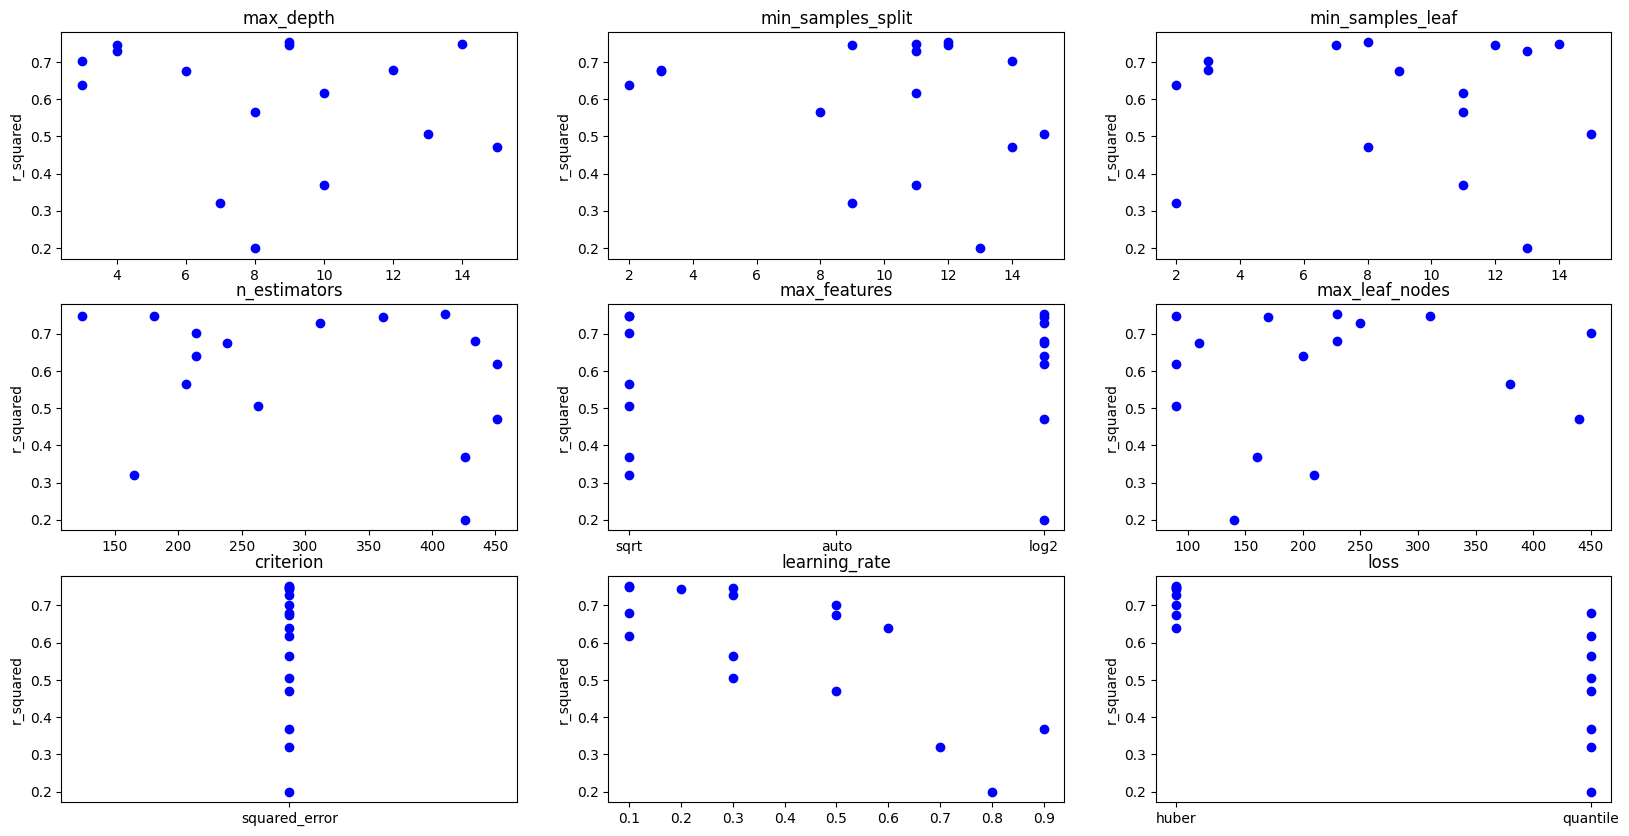

In [108]:
# plotting out the results of the hyperparameters

out = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

axs[2,1].scatter(out['param_learning_rate'], out['mean_test_score'], c='blue')
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out['param_loss'], out['mean_test_score'], c='blue')
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

## 2.4 XGBoost

In [109]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile']
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)]

# create the random grid to search for best hyperparameters
param_grid = {'criterion': criterion,
			   'n_estimators': n_estimators,
			   'max_features': max_features,
			   'max_depth': max_depth,
			   'min_samples_split': min_samples_split,
			   'min_samples_leaf': min_samples_leaf,
			   'max_leaf_nodes': max_leaf_nodes,
			   'loss': loss,
			   'learning_rate': learning_rate
}

xgb_model = xgb.XGBRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, n_iter = 100, cv = 3, verbose = 2, random_state = RANDOM_SEED, n_jobs = -1)

xgb_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "criterion", "loss", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

In [110]:
# Show the validated R^2 for the best model from the random search
best_xgb_rand = xgb_random.best_estimator_

# calculate the training and validation scores of the best estimator
xgb_train_res = best_xgb_rand.score(X_train_stand, y_train)
xgb_val_res = best_xgb_rand.score(X_val_stand, y_val)

print(str(xgb_train_res) + "\n" + str(xgb_val_res))

0.9998308470430819
0.7508369465102187


## 2.5 Evaluation

In [111]:
# This code creates a table with the type of model and training and validation data. This is to ensure that each new change the evaluation is updated automatically.

from IPython.display import Markdown as md

table_template = "|Model|Train|Validation|\n| --- | --- | --- |\n|PolynomialRegressor|{poly_train:.1%}|{poly_val:.1%}|\n|KNearestNeighbor|{knn_train:.1%}|{knn_val:.1%}|\n|RandomForestRegressor|{rf_train:.1%}|{rf_val:.1%}|\n|GradientBoostingRegressor|{gb_train:.1%}|{gb_val:.1%}|\n|XGradientBoostingRegressor|{xgb_train:.1%}|{xgb_val:.1%}|"


md(table_template.format(poly_train=poly_train_res, poly_val=poly_val_res, knn_train=knn_train_res, knn_val=knn_val_res, rf_train=rf_train_res, rf_val=rf_val_res, gb_train=gb_train_res, gb_val=gb_val_res, xgb_train=xgb_train_res, xgb_val=xgb_val_res))

|Model|Train|Validation|
| --- | --- | --- |
|PolynomialRegressor|63.0%|0.0%|
|KNearestNeighbor|89.0%|75.5%|
|RandomForestRegressor|93.6%|81.0%|
|GradientBoostingRegressor|96.8%|81.1%|
|XGradientBoostingRegressor|100.0%|75.1%|

In [112]:
# use the GradientBoostingRegressor to predict the test set
gbm_pred = best_gbm_rand.predict(X_test_stand)

# show the accuracy of the model
gbm_test_res = best_gbm_rand.score(X_test_stand, y_test)
print(gbm_test_res)

0.781343743619188


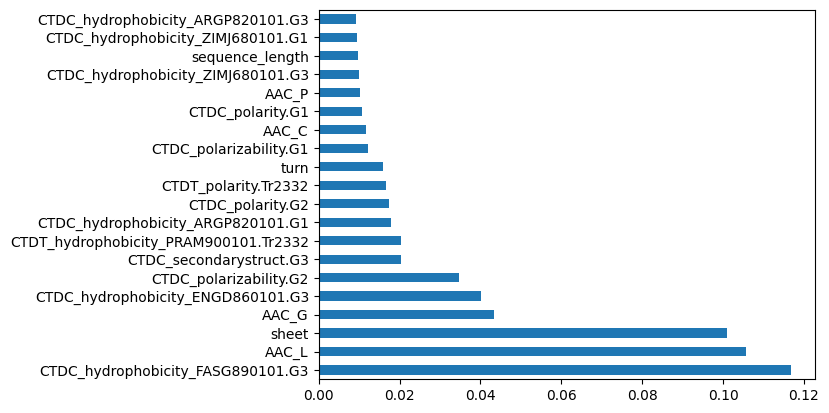

In [113]:
# show feature importance
importances = best_gbm_rand.feature_importances_

feature_importances_df = pd.Series(importances, index=X_train_stand.columns)

feature_importances_df.nlargest(20).plot(kind='barh')
plt.show()

In [114]:
# Performing one univariate linear regression per feature on the predicted values.
from sklearn.linear_model import LinearRegression

pred_train = best_gbm_rand.predict(X_train_stand)
pred_train = pd.Series(pred_train)

X = pd.DataFrame(X_train_stand)
X.columns = X_train.columns
predictors =  X_train.columns
y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)

reg = LinearRegression().fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])
for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression().fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)
betas = pd.concat([names,beta],axis=1)


# Most influential features (positive and negative)
betas.columns = ['Feature','Beta']
betas['abs'] = abs(betas['Beta'])
betas = betas.sort_values(by='abs', ascending=False)
betas = betas.drop(columns='abs')
betas.head(20)

,Feature,Beta
0,AAC_G,0.674959
0,CTDC_hydrophobicity_FASG890101.G2,0.639354
0,CTDT_polarity.Tr2332,0.626229
0,AAC_L,-0.624828
0,CTDT_hydrophobicity_FASG890101.Tr1221,0.620793
0,CTDC_polarizability.G1,0.605700
0,CTDT_hydrophobicity_PONP930101.Tr1221,0.604607
0,CTDC_hydrophobicity_ARGP820101.G1,0.601889
0,CTDC_hydrophobicity_ZIMJ680101.G3,-0.595518
0,CTDC_hydrophobicity_ARGP820101.G3,-0.593629


Mean Absolute Error (MAE): 0.48322757264566213
Mean Squared Error (MSE): 0.6298057787188999
Root Mean Squared Error (RMSE): 0.7936030359814029
R-squared (R2) Score: 0.781343743619188


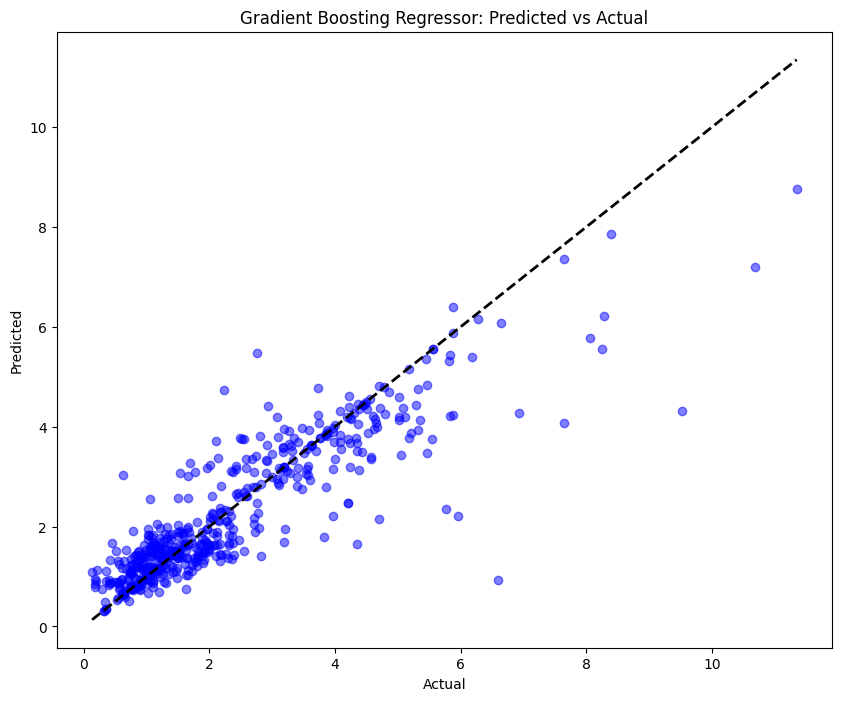

In [115]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, gbm_pred)
mse = mean_squared_error(y_test, gbm_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, gbm_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

# Plot predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, gbm_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', lw=2)
plt.title('Gradient Boosting Regressor: Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()